In [ ]:
›!pip install -q transformers datasets peft accelerate bitsandbytes scikit-learn pandas matplotlib tqdm sacrebleu rouge-score bert-score sentence-transformers faiss-cpu
!pip install --upgrade fsspec datasets
!pip install gradio --quiet›


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
  

In [ ]:
from huggingface_hub import login
login()  # Paste your token when prompted

In [ ]:

# STEP 2: Import Libraries
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import faiss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm
from google.colab import drive
import google.colab.data_table as data_table
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer
drive.mount('/content/drive')
import json
import os
from bert_score import score as bert_score
os.environ["WANDB_DISABLED"] = "true"
import gradio as gr


Mounted at /content/drive


In [ ]:
#suppress the warnings
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


 **HealthFact Dataset Preprocessing**

* Loaded the HealthFact data file from Google Drive.

* Selected the fields claim, explanation, and label.

* Dropped any rows with missing data.

* Normalized label values (converted to lowercase and stripped whitespace).

* Filtered the dataset to retain only the three relevant classes: "true", "false", and "misleading".

* [link text](https://)Printed the final cleaned dataset size and class distribution.






In [ ]:
# Load HealthFact dataset
hf_df = pd.read_json("/content/drive/MyDrive/HealthFacts/healthFact_data.json", lines=True)
hf_df.head()
hf_df = hf_df[["claim", "explanation", "label"]].dropna()
# Clean and normalize
hf_df["label"] = hf_df["label"].astype(str).str.lower().str.strip()
hf_df = hf_df[hf_df["label"].isin(["true", "false", "misleading"])]
print(f"Cleaned HealthFact dataset: {len(hf_df)} entries")

hf_df["label"].value_counts()

Cleaned HealthFact dataset: 1412 entries


,count
label,
misleading,779
false,433
true,200


 **SciFact Dataset Preprocessing**

*   Loaded the SciFact dataset from the Hugging Face Hub using the "claims" configuration, which contains scientific claims labeled with evidence.

*   Converted the Hugging Face dataset to a pandas DataFrame for easier manipulation.

*   Selected columns  claim (renamed to text) and evidence_label (renamed to label)

*   Normalized the label values:"SUPPORT" to "true" and "CONTRADICT" to "false"

*   Any other label dropped by assigning "unknown" and filtering out

*   Printed the number of cleaned samples and the label distribution to confirm the dataset is ready for training.


In [ ]:
##from datasets import load_dataset
scifact = load_dataset("allenai/scifact", "claims", split="train")
scifact_df = scifact.to_pandas()
scifact_df = scifact_df[["claim", "evidence_label"]]
scifact_df.columns = ["text", "label"]

# Normalize labels based on actual values
def normalize_label(label):
    label = str(label).strip().lower()
    if label == "support":
        return "true"
    elif label == "contradict":
        return "false"
    else:
        return "unknown"

scifact_df["label"] = scifact_df["label"].apply(normalize_label)
scifact_df = scifact_df[scifact_df["label"] != "unknown"]

print(f"Cleaned SciFact dataset: {len(scifact_df)} entries")
print(scifact_df.head())
scifact_df["label"].value_counts()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.06k [00:00<?, ?B/s]

scifact.py:   0%|          | 0.00/7.92k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.33k [00:00<?, ?B/s]

The repository for allenai/scifact contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/scifact.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1261 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/450 [00:00<?, ? examples/s]

Cleaned SciFact dataset: 957 entries
                                                 text  label
1   1 in 5 million in UK have abnormal PrP positiv...  false
4   32% of liver transplantation programs required...   true
7   40mg/day dosage of folic acid and 2mg/day dosa...   true
8   40mg/day dosage of folic acid and 2mg/day dosa...   true
16  76-85% of people with severe mental disorder r...   true


,count
label,
true,616
false,341


**Merging HealthFact and SciFact Datasets**

This code merges the cleaned HealthFact and SciFact datasets into a unified format suitable for fine-tuning. First, the claim column in the HealthFact dataset is renamed to text to match the structure of the SciFact dataset. The explanation column is dropped since it is not used in the model training process at this stage. Both datasets are reduced to contain only the text and label columns.

The two datasets are then concatenated using pd.concat() to form a single DataFrame called combined_df. To ensure data consistency, the code drops any rows with missing values in either the text or label fields. It then cleans the data by stripping whitespace from text, converting the text and label fields to string format, and standardizing all labels to uppercase (TRUE, FALSE, or MISLEADING).

Finally, the script prints the number of entries in the combined dataset and displays the distribution of labels. This merged and cleaned dataset becomes the foundation for the next step: formatting the data in ChatML style for supervised fine-tuning of the model.

In [ ]:
# Rename for compatibility
hf_df = hf_df.rename(columns={"claim": "text"})
hf_df = hf_df[["text", "label"]]
scifact_df = scifact_df[["text", "label"]]

# Combine
combined_df = pd.concat([hf_df, scifact_df], ignore_index=True)
combined_df = combined_df.dropna(subset=["text", "label"])
combined_df["text"] = combined_df["text"].astype(str).str.strip()
combined_df["label"] = combined_df["label"].astype(str).str.strip().str.upper()

print(f"Combined dataset: {len(combined_df)} entries")
print(combined_df["label"].value_counts())


Combined dataset: 2369 entries
label
TRUE          816
MISLEADING    779
FALSE         774
Name: count, dtype: int64


**Format Data in ChatML Structure**

This function format_chatml(row) converts each input example from the combined dataset into a ChatML-style prompt, which is the input format expected by instruction-tuned models like Mistral-7B-Instruct. Here's how it works:

* It extracts the text (claim), explanation, and label from a row of the dataset.

* It ensures that each field is cleaned by stripping whitespace and standardizing the label to uppercase (TRUE, FALSE, or MISLEADING).

* If the explanation field is present and non-empty, it includes it in the prompt to provide additional context for the claim. Otherwise, it formats the prompt using just the claim.

* The final prompt is wrapped inside the special <s>[INST]...[/INST]</s> tokens required by the Mistral model to distinguish between instructions and responses.

In [ ]:
def format_chatml(row):
    claim = row.get("text", "").strip()
    explanation = row.get("explanation", "").strip()
    label = row.get("label", "").strip().upper()

    instruction = (
        "Read the following medical claim carefully. Respond only with one of these labels: TRUE, FALSE, or MISLEADING — no explanation needed.\n"
    )


    if explanation:
        prompt = (
            f"<s>[INST] {instruction}\n\nClaim: {claim}\n\nExplanation: {explanation} [/INST] {label} </s>"
        )
    else:
        prompt = (
            f"<s>[INST] {instruction}\n\nClaim: {claim} [/INST] {label} </s>"
        )

    return {"text": prompt}


**Save Formatted Prompts to JSONL File for Fine-Tuning**

In [ ]:
chatml_data = combined_df.apply(format_chatml, axis=1).tolist()

with open("healthfact_balanced_3class.jsonl", "w") as f:
    for item in chatml_data:
        json.dump(item, f)
        f.write("\n")

print("ChatML JSONL saved with all 3 classes.")


ChatML JSONL saved with all 3 classes.


**Load Formatted ChatML Dataset for Training**




In [ ]:
dataset = load_dataset("json", data_files="healthfact_balanced_3class.jsonl")['train']
print(dataset)
combined_df["label"].value_counts()

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 2369
})


,count
label,
TRUE,816
MISLEADING,779
FALSE,774



**Tokenize and Prepare Dataset**

* This block sets up the dataset for Mistral-7B fine-tuning:

* Loads the Mistral tokenizer.

* Sets the pad_token to eos_token if missing.

* Defines a function to tokenize and pad text to max 512 tokens.

* Copies input_ids to labels for causal language modeling.

* Splits the dataset into 70% train and 30% test.

* Applies tokenization to both splits in batches.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", use_fast=True)

# Set pad_token if missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize(data_to_tokenize):
    toks = tokenizer(
        data_to_tokenize["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    toks["labels"] = toks["input_ids"].copy()
    return toks

split_dataset = dataset.train_test_split(test_size=0.3, seed=42)

# Tokenize with clean output
tokenized_dataset = split_dataset.map(
    tokenize,
    batched=True,
    remove_columns=["text"]
)


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Map:   0%|          | 0/1658 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

**Load Mistral-7B and apply LoRA for efficient fine-tuning**

This block loads the Mistral-7B model in 4-bit precision to reduce memory usage. It then wraps the model using LoRA (Low-Rank Adaptation) to fine-tune only key attention modules.
*  load_in_4bit=True: Uses quantized weights for memory efficiency.

*  device_map="auto": Automatically places model parts on available GPUs.

*  LoraConfig(...): Configures LoRA to adapt only q_proj and v_proj with dropout and scaling.

*  get_peft_model(...): Applies LoRA on top of the Mistral model for parameter-efficient training.


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1",
    load_in_4bit=True,
    device_map="auto"
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following TP rules were not applied on any of the layers: {'layers.*.self_attn.q_proj': 'colwise', 'layers.*.self_attn.k_proj': 'colwise', 'layers.*.self_attn.v_proj': 'colwise', 'layers.*.self_attn.o_proj': 'rowwise', 'layers.*.mlp.gate_proj': 'colwise', 'layers.*.mlp.up_proj': 'colwise', 'layers.*.mlp.down_proj': 'rowwise'}
The following layers were not sharded: model.embed_tokens.weight, model.layers.*.post_attention_layernorm.weight, lm_head.weight, model.layers.*.input_layernorm.weight, model.norm.weight


generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

**Define Training Configuration**
* output_dir="./results": Folder to save model checkpoints.

* run_name="mistral-health-scifact-stage1": Experiment name for logging.

* per_device_train_batch_size=2: Small batch size per GPU (due to large model size).

*  gradient_accumulation_steps=4: Accumulates gradients over 4 steps → effective batch size = 8.

* num_train_epochs=3: Total training duration.

* learning_rate=2e-5: AdamW optimizer learning rate.

* logging_dir="./logs": Log files saved here.

* logging_steps=10: Logs metrics every 10 steps.

* save_strategy="epoch": Saves the model at the end of every epoch.

* bf16=True: Enables bfloat16 precision if supported by hardware.

* optim="adamw_torch": Uses PyTorch’s AdamW optimizer for training.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    run_name="mistral-health-scifact-stage1",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    bf16=True,
    fp16=not torch.cuda.is_bf16_supported(),  # auto fallback if needed
    optim="adamw_torch",
    report_to="none",
    gradient_checkpointing=False,  # turn OFF if GPU is spiking
    lr_scheduler_type="cosine",  # smoother decay
)

**Initialize Trainer for fine-tuning**


*   model=model: The Mistral-7B model wrapped with LoRA adapters.

*   args=training_args: All the training hyperparameters defined earlier.

*   train_dataset=tokenized_dataset["train"]: Tokenized training data.

*   eval_dataset=tokenized_dataset["test"]: Tokenized validation data for evaluation during training.

*   tokenizer=tokenizer: Tokenizer used to preprocess input and decode outputs.




In [ ]:
# This works if you still have clean_data or split_covid

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer
)

<ipython-input-14-b812c64e33af>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


**Start the fine-tuning process**

In [ ]:
trainer.train()


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss
10,4.703700
20,1.685400
30,0.588300
40,0.510600
50,0.445600
60,0.397000
70,0.367900
80,0.321200
90,0.279400
100,0.226300


TrainOutput(global_step=624, training_loss=0.286423756621587, metrics={'train_runtime': 1506.7613, 'train_samples_per_second': 3.301, 'train_steps_per_second': 0.414, 'total_flos': 1.087038691517399e+17, 'train_loss': 0.286423756621587, 'epoch': 3.0})

**Evaluate the Fine-Tuned Model**

It runs the model on the validation dataset (test split from train_test_split) and computes the evaluation metrics defined by the Trainer. By default, this includes only the loss unless you customize it.

In [ ]:
eval_results = trainer.evaluate()
print(" Eval Results:", eval_results)


 Eval Results: {'eval_loss': 0.14830738306045532, 'eval_runtime': 44.5391, 'eval_samples_per_second': 15.964, 'eval_steps_per_second': 1.998, 'epoch': 3.0}


**Saving the Fine-Tuned Model (Stage 1)**

This block saves the fine-tuned model and tokenizer to the local directory ./mistral-health-lora-stage1. Here's what each part does:

* model.save_pretrained(...): Saves the model weights and configuration (including LoRA adapters).

* tokenizer.save_pretrained(...): Saves the tokenizer config and vocabulary used for tokenization.


In [ ]:
model.save_pretrained("./mistral-health-lora-stage1")
tokenizer.save_pretrained("./mistral-health-lora-stage1")

print("Saved stage-1 fine tuned model.")

Saved stage-1 fine tuned model.


**Batched Inference Function for Generating Model Predictions**

This function performs batched inference using a fine-tuned LLM (like Mistral). It:

* Tokenizes a list of prompts

* Generates outputs using the model

* Converts outputs back to readable strings

* Returns a list of decoded predictions

In [ ]:
def predict_labels(model, tokenizer, text_list, batch_size=4):
    # Set model to evaluation mode
    model.eval()
    predictions = []

    # Iterate over the text in batches
    for i in tqdm(range(0, len(text_list), batch_size), desc="Predicting"):
        batch = text_list[i:i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate predictions without computing gradients
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                pad_token_id=tokenizer.pad_token_id,
                max_new_tokens=10  # Adjust based on expected output length
            )

        # Decode the output tokens into strings
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded)

    return predictions


**Extract Clean Classification Label from Model Output**



In [ ]:
import re

def extract_label(text):

    # Step 1: Extract the part after [/INST]
    match = re.search(r"\[/INST\]\s*(.+?)\s*(</s>|$)", text, flags=re.IGNORECASE | re.DOTALL)
    if not match:
        return "UNKNOWN"

    response = match.group(1).strip().lower()

    # Step 2: Clean markdown/special characters
    response = re.sub(r"[*#>\-:\[\]\(\)]", " ", response)
    response = re.sub(r"\s+", " ", response).strip()

    # Step 3: Match exact label words
    if re.search(r"\btrue\b", response):
        return "TRUE"
    elif re.search(r"\bfalse\b", response):
        return "FALSE"
    elif re.search(r"\bmisleading\b", response):
        return "MISLEADING"
    elif re.search(r"\bmislead\b", response):
        return "MISLEADING"
    else:
        return "UNKNOWN"


**Model Evaluation with Classification Metrics and Confusion Matrix**

This function compares the predicted labels with the actual ground truth to assess the model's performance using standard classification metrics and a confusion matrix.

In [ ]:
def evaluate_predictions(preds, actuals):
    preds_clean = [extract_label(p) for p in preds]
    actuals_clean = [label.upper() for label in actuals]

    print("Classification Report:")
    print(classification_report(actuals_clean, preds_clean, labels=["TRUE", "FALSE", "MISLEADING"]))

    cm = confusion_matrix(actuals_clean, preds_clean, labels=["TRUE", "FALSE", "MISLEADING"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["TRUE", "FALSE", "MISLEADING"])
    disp.plot(xticks_rotation=45)


**Benchmark Sampling and Prompt Formatting for Evaluation**

This block prepares a set of test prompts to evaluate your fine-tuned model using a representative subset of your combined dataset (HealthFact + SciFact). These prompts mimic a real-world query format for inference evaluation


In [ ]:
# Sample 100 examples from combined dataset
benchmark_df_stg1 = combined_df.sample(100, random_state=42).reset_index(drop=True)
def format_instruction(row):
    instruction = (
        "You are a helpful medical assistant. Determine if the following claim is TRUE, FALSE, or MISLEADING.\n"
        "Respond only with one of these labels: TRUE, FALSE, or MISLEADING."
    )
    return f"<s>[INST] {instruction}\n\nClaim: {row['text']} [/INST]"


# Apply to your benchmark set
eval_prompts_stg1 = benchmark_df_stg1.apply(format_instruction, axis=1).tolist()
actuals_stg1 = benchmark_df_stg1["label"].tolist()  # ground truth

# Run prediction on formatted prompts
predicted_outputs_stg1 = predict_labels(model, tokenizer, eval_prompts_stg1)


Predicting: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


**Run Model Predictions and Preview Output**

This code block uses your fine-tuned model to generate predictions for 100 evaluation prompts and provides a quick preview of a few predictions compared to ground truth labels.


In [ ]:
# Run prediction on formatted prompts
#predicted_outputs_stg1 = predict_labels(model, tokenizer, eval_prompts_stg1)

# Preview few data
for i in range(30):
    print("Actual:", actuals_stg1[i])
    print("Predicted:", extract_label(predicted_outputs_stg1[i]))
    print("---")


Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: TRUE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: TRUE
---
Actual: MISLEADING
Predicted: MISLEADING
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: MISLEADING
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: MISLEADING
---
Actual: FALSE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: UNKNOWN
---
Actual: MISLEADING
Predicted: MISLEADING
---
Actual: MISLEADING
Predicted: MISLEADING
---
Actual: MISLEADING
Predicted: UNKNOWN
---
Actual: MISLEADING
Predicted: MISLEADING
---
Actual: FALSE
Predicted: FALSE
---
Actual: MISLEADING
Predicted: MISLEADING
---
Actual: TRUE
Predicted: MISLEADING
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: TRUE
Predicted: UNKNOWN
---
Actual: TRUE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: UNKNOWN
---
Actual: FALSE
Predicted: MISLEADING
---
Actual: FALSE
Predicted: MISLEADING
---
Actual: MISLEADING
Predicted: TR

**Evaluate Model Predictions with Metrics and Confusion Matrix**

This step provides a detailed, quantitative evaluation of your model’s performance after Stage 1 fine-tuning.

Classification Report:
              precision    recall  f1-score   support

        TRUE       0.69      0.64      0.67        28
       FALSE       0.48      0.32      0.38        31
  MISLEADING       0.53      0.46      0.49        41

   micro avg       0.57      0.47      0.51       100
   macro avg       0.57      0.48      0.51       100
weighted avg       0.56      0.47      0.51       100



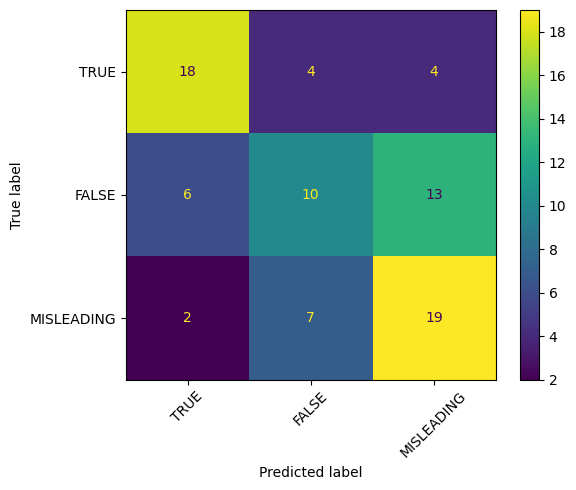

In [ ]:
evaluate_predictions(predicted_outputs_stg1, actuals_stg1)

In [ ]:

results_df_stage1 = pd.DataFrame({
    "Claim": benchmark_df_stg1["text"],  # use 'text' for Stage 1
    "Ground Truth": actuals_stg1,
    "Model Output": predicted_outputs_stg1,
    "Predicted Label": [extract_label(p) for p in predicted_outputs_stg1]
})
results_df_stage1.to_csv("stage1_predictions.csv", index=False)
results_df_stage1_data = pd.read_csv("stage1_predictions.csv")
data_table.DataTable(results_df_stage1_data)

,Claim,Ground Truth,Model Output,Predicted Label
0,New valve procedure doesn’t open heart,FALSE,[INST] You are a helpful medical assistant. De...,FALSE
1,Planned Parenthood opts out of U.S. subsidies ...,TRUE,[INST] You are a helpful medical assistant. De...,TRUE
2,"In rhesus macaques, daily subcutaneous injecti...",TRUE,[INST] You are a helpful medical assistant. De...,TRUE
3,A Guiding Hand: Robots are showing up in ever ...,MISLEADING,[INST] You are a helpful medical assistant. De...,TRUE
4,Although criticized as highly expensive additi...,MISLEADING,[INST] You are a helpful medical assistant. De...,MISLEADING
...,...,...,...,...
95,Cognitive behavioral therapy is an ineffective...,FALSE,[INST] You are a helpful medical assistant. De...,FALSE
96,Anthrax spores remain deadly until affected ar...,TRUE,[INST] You are a helpful medical assistant. De...,TRUE
97,Annual Mammography Starting at Age 40 Still Be...,MISLEADING,[INST] You are a helpful medical assistant. De...,UNKNOWN
98,Blood From Young People Safe and Just Might He...,MISLEADING,[INST] You are a helpful medical assistant. De...,MISLEADING


**Load and Merge COVID-19 Dataset with MISLEADING Samples**

In [ ]:
# Load COVID fake news dataset ---- original code
covid_ds_data = load_dataset("nanyy1025/covid_fake_news", split="train")
full_ds_test  = load_dataset("nanyy1025/covid_fake_news", split="test")
# --START ----sample to test---#
# Take only the first 50 examples
#covid_ds_data = full_ds.select(range(100))
#-----------END------------------#
# Load misleading examples from  Drive
misleading_path = "/content/drive/MyDrive/CovidDataset/covid_misleading.json"
df_misleading = pd.read_json(misleading_path, lines=True)
# Convert to Hugging Face Dataset
mis_ds = Dataset.from_pandas(df_misleading)
# Concatenate both datasets
covid_ds = concatenate_datasets([covid_ds_data, mis_ds])

#Misleading test set for bench marking and evaluation
misleading_path_test = "/content/drive/MyDrive/CovidDataset/covid_misleading_test.json"
df_misleading_test = pd.read_json(misleading_path_test, lines=True)
mis_ds_test = Dataset.from_pandas(df_misleading_test)


#Convert misleading examples into Hugging Face dataset
#mis_ds = Dataset.from_list(data_misleading)

#Concatenate both dataset
covid_ds_combined = concatenate_datasets([covid_ds_data, mis_ds])
# Take a random sample of 50 entries
covid_ds = covid_ds_combined.shuffle(seed=42)

# Verify
print(f"Random sample size: {len(covid_ds)}")
# verify data and colums
print(f"Loaded {len(covid_ds)} entries")
print(covid_ds[0])
print(covid_ds.to_pandas()["label"].value_counts())
print(full_ds_test[0])

Random sample size: 6620
Loaded 6620 entries
{'id': 931, 'tweet': 'A video of an overcrowded Shramik train claimed to be from Mumbai travelling to West Bengal.', 'label': 'fake', 'explanation': None}
label
real          3360
fake          3060
MISLEADING     200
Name: count, dtype: int64
{'id': 1, 'tweet': 'Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht', 'label': 'real'}


**Inspect COVID-19 Dataset in Pandas**

In [ ]:
# bring your dataset into pandas
pdf = covid_ds.to_pandas()

# show the first few labels and their unique set
print("Sample labels:", pdf["label"].head(10).tolist())
print("All unique labels:", pdf["label"].unique())

Sample labels: ['fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'MISLEADING', 'fake']
All unique labels: ['fake' 'real' 'MISLEADING']


**Map and Normalize Labels for COVID-19 Dataset**

This block converts raw COVID-19 dataset labels (real, fake, misleading) into standardized class labels (TRUE, FALSE, MISLEADING). It ensures consistent labeling for fine-tuning and filters out unknown or unexpected values.


In [ ]:
def map_covid_label_binary(label_data):
    # adjust this dict once you know your raw values
    label_map = {
        "real":  "TRUE",    # or 1: "TRUE"
        "fake":  "FALSE",   # or 0: "FALSE"
        "misleading": "MISLEADING"
    }
    raw = label_data["label"]
    # for string labels:
    key = str(raw).strip().lower()
    # for int labels you’d just use: key = raw

    label_data["label"] = label_map.get(key, "UNKNOWN")
    return label_data

covid_ds = covid_ds.map(map_covid_label_binary)
full_ds_test = full_ds_test.map(map_covid_label_binary)

# drop anything that didn’t map
covid_ds = covid_ds.filter(lambda x: x["label"] != "UNKNOWN")

print(covid_ds.to_pandas()["label"].value_counts())


Map:   0%|          | 0/6620 [00:00<?, ? examples/s]

Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6620 [00:00<?, ? examples/s]

label
TRUE          3360
FALSE         3060
MISLEADING     200
Name: count, dtype: int64


**Format COVID Dataset into ChatML Structure for Fine-Tuning**

This code formats the normalized COVID-19 dataset into the ChatML prompt-response format expected by instruction-tuned models like Mistral. Each entry is saved in a .jsonl file, making it ready for tokenization and training.


In [ ]:
def format_chatml_binary(example):
    instruction = (
        "You are a helpful medical assistant. Determine if the following claim is TRUE, FALSE, or MISLEADING.\n"
        "Respond only with one of these labels: TRUE, FALSE, or MISLEADING."
    )

    claim = example.get("tweet", "").strip()
    label = example.get("label", "").strip().upper()

    return {
        "text": (
            f"<s>[INST] {instruction}\n\nClaim: {claim} [/INST] {label} </s>"
        )
    }


# Apply and dump
chatml_binary = covid_ds.map(format_chatml_binary)
with open("covid19_binary_chatml.jsonl", "w") as out:
    for rec in chatml_binary:
        json.dump(rec, out)
        out.write("\n")

print("Saved covid19_binary_chatml.jsonl with TRUE/FALSE/MISLEADING labels.")


Map:   0%|          | 0/6620 [00:00<?, ? examples/s]

Saved covid19_binary_chatml.jsonl with TRUE/FALSE/MISLEADING labels.


**Load and Clean COVID ChatML Dataset for Tokenization**

This block loads the previously saved covid19_binary_chatml.jsonl into a Hugging Face dataset and strips away any unused metadata columns to retain only the formatted text. The result is a clean dataset ready for tokenization and fine-tuning.


In [ ]:
covid_data = load_dataset("json", data_files="covid19_binary_chatml.jsonl")["train"]
print(covid_data.column_names)
# Drop all original columns, keep only the newly formatted "text"
clean_data = covid_data.map(
    format_chatml_binary,
    remove_columns=covid_data.column_names  # this rips out id, tweet, label, etc.
)
print(clean_data.column_names)  # should output: ['text']

Generating train split: 0 examples [00:00, ? examples/s]

['id', 'tweet', 'label', 'explanation', 'text']


Map:   0%|          | 0/6620 [00:00<?, ? examples/s]

['text']


**Tokenize COVID-19 ChatML Data for Causal Language Modeling (CLM)**

This code prepares the dataset for causal language model fine-tuning (like Mistral-7B) by tokenizing the ChatML-formatted prompts and creating appropriate input and label tensors. It removes the "text" column after tokenization to retain only what's needed: input_ids, attention_mask, and labels.

In [ ]:
def tokenize_for_clm(covidaData):
    toks = tokenizer(
        covidaData["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    # key trick: for causal LM we train the model to reproduce the entire input,
    # so the labels are just a copy of input_ids
    toks["labels"] = toks["input_ids"].copy()
    return toks

# Tokenize with clean output

covid_tokenized = clean_data.map(
    tokenize_for_clm,
    batched=True,
    remove_columns=["text"],  # now only input_ids, attention_mask, labels remain
)

print(covid_tokenized.column_names)
# should be ['input_ids','attention_mask','labels']
print("Before tokenization:", len(clean_data))  # Should match jsonl
print("After tokenization:", len(covid_tokenized))
!head -n 3 covid19_binary_chatml.jsonl


Map:   0%|          | 0/6620 [00:00<?, ? examples/s]

['input_ids', 'attention_mask', 'labels']
Before tokenization: 6620
After tokenization: 6620
{"id": 931, "tweet": "A video of an overcrowded Shramik train claimed to be from Mumbai travelling to West Bengal.", "label": "FALSE", "explanation": null, "text": "<s>[INST] You are a helpful medical assistant. Determine if the following claim is TRUE, FALSE, or MISLEADING.\nRespond only with one of these labels: TRUE, FALSE, or MISLEADING.\n\nClaim: A video of an overcrowded Shramik train claimed to be from Mumbai travelling to West Bengal. [/INST] FALSE </s>"}
{"id": 1171, "tweet": "\u201cAs we mark 100 days since our first case of #COVID19Nigeria we remember over 300 people we\u2018ve lost to this outbreak. As we publish the daily Situation Reports we remember the humans &amp; loved ones behind these numbers\u201d ~ @Chikwe_I on @TVCconnect https://t.co/wGfUmgxjrp", "label": "TRUE", "explanation": null, "text": "<s>[INST] You are a helpful medical assistant. Determine if the following claim

**Applying LoRA to Mistral Model for Efficient Fine-Tuning**

This code applies Low-Rank Adaptation (LoRA) to the previously loaded Mistral model, enabling efficient parameter-efficient fine-tuning. LoRA introduces small trainable matrices into the attention layers while freezing most of the original model weights, making the process lightweight and faster to train.

* r: Smaller values mean fewer parameters (memory efficient).


* lora_alpha: Adjusts the impact of the LoRA weights.


* lora_dropout: Prevents overfitting within the LoRA path.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

model = get_peft_model(model, lora_config)  # Re-wrap with LoRA
model.config.use_cache = False


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'mistralai/Mistral-7B-v0.1' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


**Fine-Tuning Mistral Stage 2 on COVID-19 with LoRA**

This block defines training arguments for Stage 2 fine-tuning on the COVID-19 dataset using the Hugging Face Trainer API and the LoRA-wrapped Stage 1 Mistral model. It then initiates training using these configurations.

In [ ]:
training_args_stage2 = TrainingArguments(
    output_dir="./mistral_stage2_covid_binary",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,
    save_total_limit=2,
    report_to="none",
    remove_unused_columns=False
)
#split_covid = covid_tokenized.train_test_split(test_size=0.3, seed=42)
trainer_stg2 = Trainer(
    model=model,  # This is existing LoRA-wrapped Stage 1 model
    args=training_args_stage2,
    train_dataset=covid_tokenized,
    #eval_dataset=covid_tokenized["test"],
    tokenizer=tokenizer,
)
trainer_stg2.train()


<ipython-input-33-a1402e1d0de9>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stg2 = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,1.733200
20,0.477600
30,0.369100
40,0.330800
50,0.337100
60,0.314100
70,0.289000
80,0.298100
90,0.281300
100,0.298200


TrainOutput(global_step=2484, training_loss=0.23328491263151552, metrics={'train_runtime': 4237.1061, 'train_samples_per_second': 4.687, 'train_steps_per_second': 0.586, 'total_flos': 4.3402871760224256e+17, 'train_loss': 0.23328491263151552, 'epoch': 3.0})

**Saving the Stage 2 Fine-Tuned Model and Tokenizer**


In [ ]:
#eval_results_stg2 = trainer_stg2.evaluate()
#print(" Eval Results:", eval_results_stg2)


 Eval Results: {'eval_loss': 0.2072962373495102, 'eval_runtime': 6.36, 'eval_samples_per_second': 15.723, 'eval_steps_per_second': 2.044, 'epoch': 3.0}


In [ ]:
model.save_pretrained("mistral_stage2_covid_binary")
tokenizer.save_pretrained("mistral_stage2_covid_binary")

('mistral_stage2_covid_binary/tokenizer_config.json',
 'mistral_stage2_covid_binary/special_tokens_map.json',
 'mistral_stage2_covid_binary/tokenizer.model',
 'mistral_stage2_covid_binary/added_tokens.json',
 'mistral_stage2_covid_binary/tokenizer.json')

**Benchmark Sampling and Prompt Formatting for Stage 2 Evaluation**

* Selects 100 random samples (sample(100)) from the COVID dataset for evaluation.

* Converts each row into a formatted ChatML prompt using the same pattern as during training.

* Collects the actual labels to later compare with model predictions.

In [ ]:
covid_ds_test_combined = concatenate_datasets([full_ds_test.select(range(80)), mis_ds_test])
benchmark_df_covid = covid_ds_test_combined.to_pandas().sample(100, random_state=42).reset_index(drop=True)
print(covid_ds_test_combined[0])
def format_prompt(row):
    instruction = (
        "You are a helpful medical assistant. Determine if the following claim is TRUE, FALSE, or MISLEADING.\n"
        "Respond only with one of these labels: TRUE, FALSE, or MISLEADING."
    )

    claim = row.get("tweet", "").strip()

    return f"<s>[INST] {instruction}\n\nClaim: {claim} [/INST]"

eval_texts = benchmark_df_covid.apply(format_prompt, axis=1).tolist()

actuals = benchmark_df_covid["label"].tolist()


{'id': 1, 'tweet': 'Our daily update is published. States reported 734k tests 39k new cases and 532 deaths. Current hospitalizations fell below 30k for the first time since June 22. https://t.co/wzSYMe0Sht', 'label': 'TRUE'}


**Predict Labels Using Fine-Tuned Model (Stage 2 Inference)**

This function runs batched inference using your LoRA-fine-tuned Mistral model. It tokenizes prompts, performs text generation, and returns decoded model responses. You’ll use this to predict the TRUE/FALSE labels for benchmark COVID-19 claims.


In [ ]:
#moved this code to predic label to re use the existing one

**Stage 2 model’s predictions**

In [ ]:
predicted_outputs = predict_labels(model, tokenizer, eval_texts)

Predicting: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


**Label Extraction & Standardization**

In [ ]:
def extract_label_from_response(text):
    text = text.strip()

    # Step 1: Extract text after [/INST]
    match_inst = re.search(r"\[/INST\]\s*(.*?)\s*(</s>|$)", text, flags=re.IGNORECASE | re.DOTALL)
    if match_inst:
        response = match_inst.group(1).strip().lower()

        # Step 2: Remove markdown/special chars
        response = re.sub(r"[*#>\-:\[\]\(\)]", " ", response)
        response = re.sub(r"\s+", " ", response).strip()

        # Step 3: Match exact labels
        if re.fullmatch(r"true", response):
            return "TRUE"
        elif re.fullmatch(r"false", response):
            return "FALSE"
        elif re.fullmatch(r"misleading", response):
            return "MISLEADING"

        # Step 4: Fuzzy fallback
        for lbl in ["true", "false", "misleading"]:
            if lbl in response:
                return lbl.upper()

    # Step 5: Final fallback – search anywhere
    text = text.lower()
    for lbl in ["true", "false", "misleading"]:
        if lbl in text:
            return lbl.upper()

    return "UNKNOWN"




predicted_labels_stg2 = [extract_label_from_response(p) for p in predicted_outputs]

In [ ]:
# Preview few data
for i in range(30):
    print("Actual:", actuals[i])
    print("Predicted:", extract_label_from_response(predicted_outputs[i]))
    print("---")

Actual: FALSE
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: FALSE
---
Actual: FALSE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: TRUE
Predicted: TRUE
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: FALSE
---
Actual: MISLEADING
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Predicted: FALSE
---
Actual: FALSE
Predicted: FALSE
---
Actual: TRUE
Predicted: TRUE
---
Actual: FALSE
Pr

**Evaluation: Classification Report & Confusion Matrix**

This code evaluates the performance of Stage 2 COVID fine-tuned model. It compares the predicted labels with the actual ground truth using classification_report to show precision, recall, and F1-score for each class (TRUE, FALSE, MISLEADING). It also computes and visualizes a confusion matrix to highlight where the model's predictions match or misclassify the actual labels. This helps identify strengths and weaknesses in model performance across the three classes.


              precision    recall  f1-score   support

       FALSE       0.62      0.97      0.76        37
  MISLEADING       1.00      0.12      0.21        25
        TRUE       0.97      1.00      0.99        38

    accuracy                           0.77       100
   macro avg       0.87      0.70      0.65       100
weighted avg       0.85      0.77      0.71       100



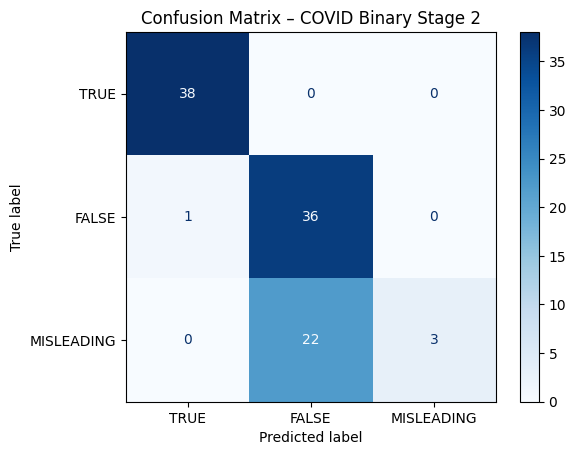

In [ ]:
print(classification_report(actuals, predicted_labels_stg2))

cm = confusion_matrix(actuals, predicted_labels_stg2, labels=["TRUE", "FALSE", "MISLEADING"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["TRUE", "FALSE", "MISLEADING"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – COVID Binary Stage 2")
plt.show()

**Creating Evaluation Results DataFrame**

* Claim – the input tweet or medical claim,

* Ground Truth – the actual label from the benchmark set,

* Model Output – the raw generated text from the model,

* Predicted Label – the extracted prediction label (TRUE, FALSE, or MISLEADING).

In [ ]:
results_df_covid = pd.DataFrame({
    "Claim": benchmark_df_covid["tweet"],
    "Ground Truth": actuals,
    "Model Output": predicted_outputs,
    "Predicted Label": predicted_labels_stg2
})

**Saving the Evaluation Results**

In [ ]:
results_df_covid.to_csv("covid_stage2_predictions.csv", index=False)
print("Saved results to covid_stage2_predictions.csv")
results_df_covid_data = pd.read_csv("covid_stage2_predictions.csv")
data_table.DataTable(results_df_covid_data)

Saved results to covid_stage2_predictions.csv


,Claim,Ground Truth,Model Output,Predicted Label
0,"Tablik Jamaat Chief Maulana Saad: ""If 70000 pe...",FALSE,[INST] You are a helpful medical assistant. De...,FALSE
1,Two interesting correlations:\n\n1) Children t...,FALSE,[INST] You are a helpful medical assistant. De...,FALSE
2,This is the sixth time a global health emergen...,TRUE,[INST] You are a helpful medical assistant. De...,TRUE
3,Eating garlic prevents coronavirus infection.,MISLEADING,[INST] You are a helpful medical assistant. De...,FALSE
4,The coronavirus is only as dangerous as a flu ...,FALSE,[INST] You are a helpful medical assistant. De...,FALSE
...,...,...,...,...
95,President Trump Asked What He Would Do If He W...,FALSE,[INST] You are a helpful medical assistant. De...,FALSE
96,"President Donald Trump tweeted, ""Coronavirus v...",FALSE,[INST] You are a helpful medical assistant. De...,FALSE
97,Vaccinated individuals shed the virus and infe...,MISLEADING,[INST] You are a helpful medical assistant. De...,FALSE
98,COVID-19 spreads through mosquito bites.,MISLEADING,[INST] You are a helpful medical assistant. De...,FALSE


**TRUST SCORE**

Loading the Embedding Model for Trust Score

In [ ]:
# Load a small but effective embedding model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.weight, embeddings.position_embeddings.weight, pooler.dense.bias, encoder.layer.*.attention.self.value.bias, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.weight, pooler.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.weight


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**Computing Trust Scores Using Semantic Similarity**

This block evaluates how semantically similar the model’s output is to the original claim using cosine similarity, helping estimate the "trustworthiness" of the model's prediction.

In [ ]:
# Use input Claim and Model Output columns
claims = results_df_covid["Claim"].tolist()
responses = results_df_covid["Model Output"].tolist()

# Compute embeddings in batches
claim_embeddings = embedder.encode(claims, convert_to_tensor=True)
response_embeddings = embedder.encode(responses, convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(claim_embeddings, response_embeddings)

# Convert diagonal of cosine similarity matrix into list
trust_scores = [round(score.item(), 3) for score in cosine_scores.diag()]

# Add to DataFrame
results_df_covid["Trust Score"] = trust_scores

# Preview
results_df_covid[["Claim", "Predicted Label", "Trust Score"]].head()


,Claim,Predicted Label,Trust Score
0,"Tablik Jamaat Chief Maulana Saad: ""If 70000 pe...",FALSE,0.594
1,Two interesting correlations:\n\n1) Children t...,FALSE,0.651
2,This is the sixth time a global health emergen...,TRUE,0.578
3,Eating garlic prevents coronavirus infection.,FALSE,0.416
4,The coronavirus is only as dangerous as a flu ...,FALSE,0.561


**Evaluation Results with Trust Scores**


In [ ]:
results_df_covid.to_csv("covid_stage2_with_trust_score.csv", index=False)
print(" Saved with trust scores to covid_stage2_with_trust_score.csv")

 Saved with trust scores to covid_stage2_with_trust_score.csv


**Merging Stage 1 and Stage 2 Results for Final Evaluation**

To support holistic performance analysis, combining prediction outputs from both Stage 1 and Stage 2 into a single consolidated file.

In [ ]:

# Load Stage 1 and Stage 2 results
s1 = pd.read_csv("stage1_predictions.csv")
s2 = pd.read_csv("covid_stage2_predictions.csv")

# Tag the source stage
s1["Stage"] = "Stage 1"
s1 = s1.rename(columns={"Model Output": "Model Output", "Predicted Label": "Prediction"})

s2["Stage"] = "Stage 2"
s2 = s2.rename(columns={"Model Output": "Model Output", "Predicted Label": "Prediction"})

# Standardize column names for alignment
s1 = s1[["Claim", "Ground Truth", "Model Output", "Prediction", "Stage"]]
s2 = s2[["Claim", "Ground Truth", "Model Output", "Prediction", "Stage"]]

# Append them row-wise
combined = pd.concat([s1, s2], ignore_index=True)

# Save
combined.to_csv("combined_stage1_stage2_predictions.csv", index=False)

# Display if needed
data_table.DataTable(combined)


,Claim,Ground Truth,Model Output,Prediction,Stage
0,New valve procedure doesn’t open heart,FALSE,[INST] You are a helpful medical assistant. De...,FALSE,Stage 1
1,Planned Parenthood opts out of U.S. subsidies ...,TRUE,[INST] You are a helpful medical assistant. De...,TRUE,Stage 1
2,"In rhesus macaques, daily subcutaneous injecti...",TRUE,[INST] You are a helpful medical assistant. De...,TRUE,Stage 1
3,A Guiding Hand: Robots are showing up in ever ...,MISLEADING,[INST] You are a helpful medical assistant. De...,TRUE,Stage 1
4,Although criticized as highly expensive additi...,MISLEADING,[INST] You are a helpful medical assistant. De...,MISLEADING,Stage 1
...,...,...,...,...,...
195,President Trump Asked What He Would Do If He W...,FALSE,[INST] You are a helpful medical assistant. De...,FALSE,Stage 2
196,"President Donald Trump tweeted, ""Coronavirus v...",FALSE,[INST] You are a helpful medical assistant. De...,FALSE,Stage 2
197,Vaccinated individuals shed the virus and infe...,MISLEADING,[INST] You are a helpful medical assistant. De...,FALSE,Stage 2
198,COVID-19 spreads through mosquito bites.,MISLEADING,[INST] You are a helpful medical assistant. De...,FALSE,Stage 2


In [ ]:
# Load and Fix Labels


# Load combined Stage 1 + Stage 2 data
df = pd.read_csv("combined_stage1_stage2_predictions.csv")

# Normalize to uppercase
df["Ground Truth"] = df["Ground Truth"].astype(str).str.upper()
df["Prediction"] = df["Prediction"].astype(str).str.upper()

# Optional: Check label consistency
print(df["Stage"].value_counts())
print(df[["Ground Truth", "Prediction", "Stage"]].dtypes)

# Separate Stage 1 and Stage 2
df_s1 = df[df["Stage"] == "Stage 1"]
df_s2 = df[df["Stage"] == "Stage 2"]

# Run Classification Reports
report_s1 = classification_report(
    df_s1["Ground Truth"],
    df_s1["Prediction"],
    labels=["TRUE", "FALSE", "MISLEADING"],
    output_dict=True
)

report_s2 = classification_report(
    df_s2["Ground Truth"],
    df_s2["Prediction"],
    labels=["TRUE", "FALSE", "MISLEADING"],
    output_dict=True
)

# Display summary
print("Stage 1 Summary")
print(classification_report(df_s1["Ground Truth"], df_s1["Prediction"], labels=["TRUE", "FALSE", "MISLEADING"]))

print("Stage 2 Summary")
print(classification_report(df_s2["Ground Truth"], df_s2["Prediction"], labels=["TRUE", "FALSE", "MISLEADING"]))


Stage
Stage 1    100
Stage 2    100
Name: count, dtype: int64
Ground Truth    object
Prediction      object
Stage           object
dtype: object
Stage 1 Summary
              precision    recall  f1-score   support

        TRUE       0.69      0.64      0.67        28
       FALSE       0.48      0.32      0.38        31
  MISLEADING       0.53      0.46      0.49        41

   micro avg       0.57      0.47      0.51       100
   macro avg       0.57      0.48      0.51       100
weighted avg       0.56      0.47      0.51       100

Stage 2 Summary
              precision    recall  f1-score   support

        TRUE       0.97      1.00      0.99        38
       FALSE       0.62      0.97      0.76        37
  MISLEADING       1.00      0.12      0.21        25

    accuracy                           0.77       100
   macro avg       0.87      0.70      0.65       100
weighted avg       0.85      0.77      0.71       100



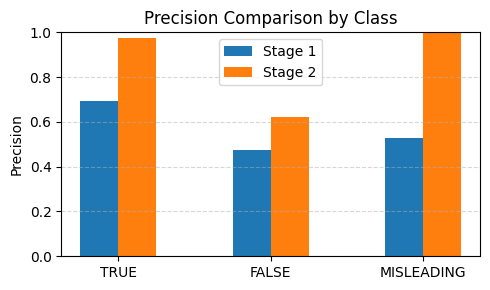

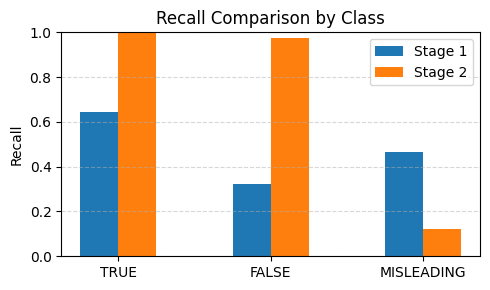

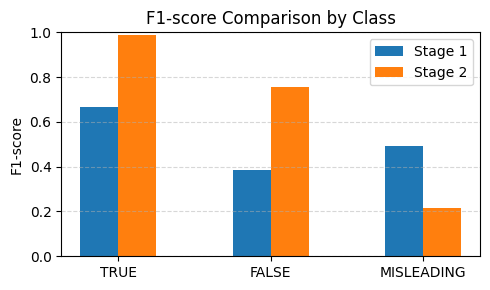

In [ ]:
# Labels and metrics
classes = ["TRUE", "FALSE", "MISLEADING"]
metrics = ["precision", "recall", "f1-score"]

# Set up the plot
x = np.arange(len(classes))  # label locations
width = 0.25  # width of the bars

# Prepare the metric values
def extract_metric(report, metric):
    return [report[c][metric] for c in classes]

for metric in metrics:
    s1_vals = extract_metric(report_s1, metric)
    s2_vals = extract_metric(report_s2, metric)

    # Plotting with smaller size (e.g., 6x4 inches)
    fig, ax = plt.subplots(figsize=(5, 3))  # ✅ reduce size here
    ax.bar(x - width/2, s1_vals, width, label="Stage 1")
    ax.bar(x + width/2, s2_vals, width, label="Stage 2")

    # Labels and formatting
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} Comparison by Class")
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    plt.ylim(0, 1)  # all metrics are between 0 and 1
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()  # ✅ make sure layout doesn’t overlap
    plt.show()


**UI Implementation**

This block defines the interactive prediction logic for the Stage 2 fine-tuned Mistral-7B model. It includes:

* Loading the all-MiniLM-L6-v2 sentence embedding model to compute trust scores based on semantic similarity.

* A format_input_prompt() function that structures user-provided claims into a ChatML-style instruction prompt for inference.

* A classify_claim() function that:

  * Formats the input claim

  * Generates a prediction using the fine-tuned model

  * Extracts the classification label (TRUE / FALSE / MISLEADING)

  * Computes a trust score by comparing the claim and model output using cosine similarity of embeddings

This function is designed to be connected with a Gradio UI for real-time misinformation classification and confidence scoring.

In [ ]:

# Load trust scorer
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Prompt formatter
def format_input_prompt(claim):
    instruction = (
        "You are a helpful medical assistant. Determine if the following claim is TRUE, FALSE, or MISLEADING.\n"
        "Respond only with one of these labels: TRUE, FALSE, or MISLEADING."
    )

    return f"<s>[INST] {instruction}\n\nClaim: {claim} [/INST]"

# UI enabling function
def classify_claim(claim):
    # Format the prompt for the model
    prompt = format_input_prompt(claim)

    # Run inference
    output = predict_labels(model, tokenizer, [prompt])[0]

    # Extract label
    label = extract_label_from_response(output)

    # Compute trust score
    claim_embedding = embedder.encode(claim, convert_to_tensor=True)
    response_embedding = embedder.encode(output, convert_to_tensor=True)
    trust_score = util.cos_sim(claim_embedding, response_embedding).item()

    # Format a cleaner display output
    display_text = f"Your claim:\n\n“{claim}”\n\nis classified as → **{label}**"

    return label, display_text, round(trust_score, 3)



The following layers were not sharded: embeddings.token_type_embeddings.weight, embeddings.LayerNorm.weight, embeddings.LayerNorm.bias, encoder.layer.*.attention.self.key.bias, encoder.layer.*.attention.self.value.weight, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.self.key.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.attention.output.LayerNorm.weight, embeddings.position_embeddings.weight, pooler.dense.bias, encoder.layer.*.attention.self.value.bias, embeddings.word_embeddings.weight, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.self.query.bias, encoder.layer.*.attention.output.dense.weight, pooler.dense.weight, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.intermediate.dense.weight


**Gradio interface**

Code block to create gradio interface, which allows users to enter a COVID-19-related claim and get a prediction from the fine-tuned Mistral-7B model. The model classifies the claim as TRUE, FALSE, or MISLEADING


In [ ]:
interface = gr.Interface(
    fn=classify_claim,
    inputs=gr.Textbox(lines=4, label="Enter a COVID-19 Claim"),
    outputs=[
        gr.Label(label="Predicted Label"),
        gr.Markdown(label="Explanation"),
        gr.Number(label="Trust Score (0–1)")
    ],
    title="COVID-19 Misinformation Classifier (Mistral-7B)",
    description="This model classifies COVID-related claims as TRUE, FALSE, or MISLEADING using a fine-tuned Mistral-7B model.",
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://08d1da8b237002b3a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
